# Explorative Data Analysis - CO2 Emissions

## Objective
In this notebook, the CO₂ emissions based on the fuel consumption of vehicles in Canada in 2020 are analyzed. The main objective is to identify features of vehicles that affect the amount of emissions the most. Other objectives are 

## Data
The dataset used in this notebook is publisehd in: https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64#wb-auto-6


## Steps
The steps taken in this notebook:
- [Step 1](#step_1)
    : Importing Libraries and Dataset
- [Step 2](#step_2)
    : Dataset Informations + Data Quality
- [Step 3](#step_3)
    : Car Manufacturers
- [Step 4](#step_4)
    : Vehicle Classes
- [Step 5](#step_5)
    : Number Cylinders and Engine Size   
- [Step 6](#step_6)
    : Fuel Type      
- [Step 7](#step_7)
    : Correlations          

## <a id="step_1">Step 1: Importing Libraries and Dataset</a>

In [74]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import colorcet as cc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# nrows is set to 967, since the csv file includes a describtion of the columns below the actual table, making it necessary to specify nrows to only include the table 
df = pd.read_csv(os.path.join('Datasets','MY2020 Fuel Consumption Ratings.csv'), header=[0,1], nrows=967)

## <a id="step_2">Step 2: Dataset Informations  + Data Quality</a>

The dataset contains model-specific fuel consumption and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada 

To understand the dataset, the csv file contains following explainations:
#### Model
- 4WD/4X4 = Four-wheel drive
- AWD = All-wheel drive
- FFV = Flexible-fuel vehicle
- SWB = Short wheelbase
- LWB = Long wheelbase
- EWB = Extended wheelbase
#### Transmission	
- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual
- 3 – 10 = Number of gears
#### Fuel type
- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas
#### Fuel consumption
City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg)
#### CO2 emissions
the tailpipe emissions of carbon dioxide (in grams per kilometre) for combined city and highway driving
#### CO2 rating
the tailpipe emissions of carbon dioxide rated on a scale from 1 (worst) to 10 (best)
#### Smog rating
the tailpipe emissions of smog-forming pollutants rated on a scale from 1 (worst) to 10 (best)


In [4]:
df.head()

,Model,Make,Model,Vehicle Class,Engine Size,Cylinders,Transmission,Fuel,Fuel Consumption,Unnamed: 9_level_0,...,Unnamed: 211_level_0,Unnamed: 212_level_0,Unnamed: 213_level_0,Unnamed: 214_level_0,Unnamed: 215_level_0,Unnamed: 216_level_0,Unnamed: 217_level_0,Unnamed: 218_level_0,Unnamed: 219_level_0,Unnamed: 220_level_0
,Year,Unnamed: 1_level_1,Unnamed: 2_level_1,Unnamed: 3_level_1,(L),Unnamed: 5_level_1,Unnamed: 6_level_1,Type,City (L/100 km),Hwy (L/100 km),...,Unnamed: 211_level_1,Unnamed: 212_level_1,Unnamed: 213_level_1,Unnamed: 214_level_1,Unnamed: 215_level_1,Unnamed: 216_level_1,Unnamed: 217_level_1,Unnamed: 218_level_1,Unnamed: 219_level_1,Unnamed: 220_level_1
0,2020,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS9,Z,12.3,9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6,AS9,Z,12.2,9.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,Acura,MDX Hybrid AWD,SUV: Small,3.0,6,AM7,Z,9.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,Acura,RDX AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains a lot of completely empty columns, so at first, all columns that contain not a single value are dropped
Further, the second row filled the headers with unnecessary information, which will be renamed

In [5]:
df = df.dropna(axis=1, how='all')

cols_level0 = df.columns.get_level_values(level=0).str.replace('Unnamed.*','Fuel Consumption')
cols_level1 = df.columns.get_level_values(level=1).str.replace('Unnamed.*','')
df.columns = [cols_level0,cols_level1]

In [6]:
# Flatten multiindex columns to simplify the analysis and avoid PerformanceWarnings
df.columns = [' '.join(col).strip() for col in df.columns.values]

In [7]:
df.head()

,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions (g/km),CO2 Rating,Smog Rating
0,2020,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,199,6,3
1,2020,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS9,Z,12.3,9.2,10.9,26,254,4,3
2,2020,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6,AS9,Z,12.2,9.5,11.0,26,258,4,3
3,2020,Acura,MDX Hybrid AWD,SUV: Small,3.0,6,AM7,Z,9.1,9.0,9.0,31,210,5,3
4,2020,Acura,RDX AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Model Year                        967 non-null    int64  
 1   Make                              967 non-null    object 
 2   Model                             967 non-null    object 
 3   Vehicle Class                     967 non-null    object 
 4   Engine Size (L)                   967 non-null    float64
 5   Cylinders                         967 non-null    int64  
 6   Transmission                      967 non-null    object 
 7   Fuel Type                         967 non-null    object 
 8   Fuel Consumption City (L/100 km)  967 non-null    float64
 9   Fuel Consumption Hwy (L/100 km)   967 non-null    float64
 10  Fuel Consumption Comb (L/100 km)  967 non-null    float64
 11  Fuel Consumption Comb (mpg)       967 non-null    int64  
 12  CO2 Emis

As can be seen in the info, the dataset not a single NaN value in the remaining columns. So there is no need to apply any imputation methods to handle missing values.

Further, the dataset contains 5 categorical columns that need to be encoded when training most machine learning algorithms. The remaining columns are containing integers and floats. The variables that are suitable for use as target variables when training an algorithm, such as CO₂ emissions or smog, are available as integers.

In [9]:
# df.describe()

## <a id="step_3">Step 3: Car Manufacturers</a>

Which manufacturers are present in the dataset?

In [10]:
df['Make'].unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'Bentley', 'BMW',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge',
       'FIAT', 'Ford', 'Genesis', 'GMC', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Maserati', 'Mazda', 'Mercedes-Benz', 'MINI',
       'Mitsubishi', 'Nissan', 'Porsche', 'Ram', 'Rolls-Royce', 'Subaru',
       'Toyota', 'Volkswagen', 'Volvo'], dtype=object)

Are there different amount of Models per manufacturer in the dataset? If so, which manufacturers are represented more/less often represented due to the amount of different vehicles included? 

<AxesSubplot:xlabel='index', ylabel='Make'>

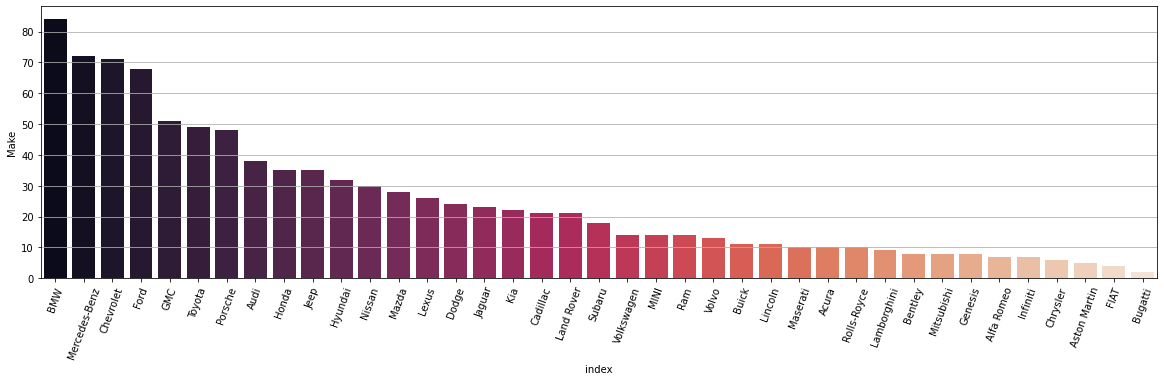

In [11]:
manufacturers_counts = df['Make'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_counts, x=manufacturers_counts['index'], y=manufacturers_counts[manufacturers_counts.columns[1]], palette="rocket")

#### Average CO2 emissions per manufacturer 

<AxesSubplot:xlabel='Make', ylabel='CO2 Emissions (g/km)'>

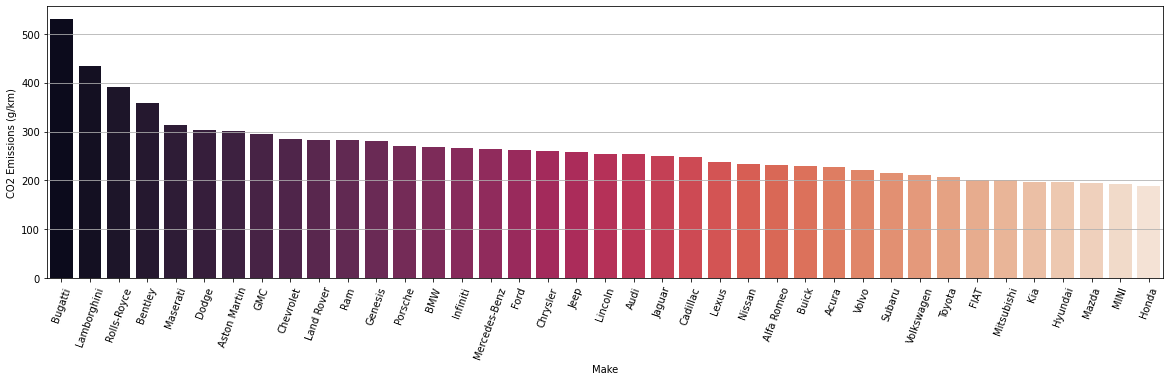

In [12]:
manufacturers_CO2 = df.groupby('Make').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=manufacturers_CO2, x=manufacturers_CO2['Make'], y=manufacturers_CO2['CO2 Emissions (g/km)'], palette="rocket")


On average, the vehicles by the car manufacturers 'Bugatti', 'Lamborghini' and 'Rolls-Royce' emit the most CO2 (g/km). That is expected since Bugatti and Lamborghini are super sportscar producer and rolls royce also mostly has very heavy cars with a lot of power. Let's check for these three manufacturers the number of cylinders and the engine sizes in relation to the other manufacturers

<AxesSubplot:xlabel='Cylinders', ylabel='Engine Size (L)'>

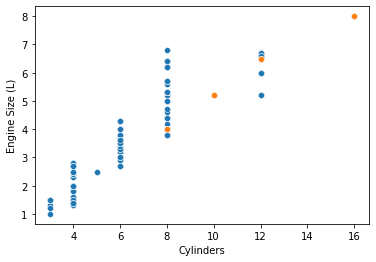

<Figure size 1440x360 with 0 Axes>

In [13]:
fig, ax = plt.subplots()
plt.figure(figsize=(20,5))
sns.scatterplot(data=df, x='Cylinders', y='Engine Size (L)', ax=ax)
sns.scatterplot(data=df[df["Make"].str.contains("Bugatti|Lamborghini|Rolls Royce")], x='Cylinders', y='Engine Size (L)', ax=ax)

In [14]:
df[df["Make"].str.contains("Bugatti|Lamborghini|Rolls Royce")][df['Cylinders'] == 8]

C:\Users\Johannes\AppData\Local\Temp/ipykernel_19204/42329695.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Make"].str.contains("Bugatti|Lamborghini|Rolls Royce")][df['Cylinders'] == 8]


,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions (g/km),CO2 Rating,Smog Rating
580,2020,Lamborghini,Urus,SUV: Standard,4.0,8,AS8,Z,19.2,14.1,16.9,17,384,1,3


The models of these manufacturers are in the higher spectrums of the cylinder numbers and engine sizes, although one model (8 Cylinders and 4L Engine Size) is in the midfield of the data. This is the SUV Lamborghini Urus, which has the lowest possible CO2 rating.

Let's check the disitribution of CO2 emissions of the different manufacturers

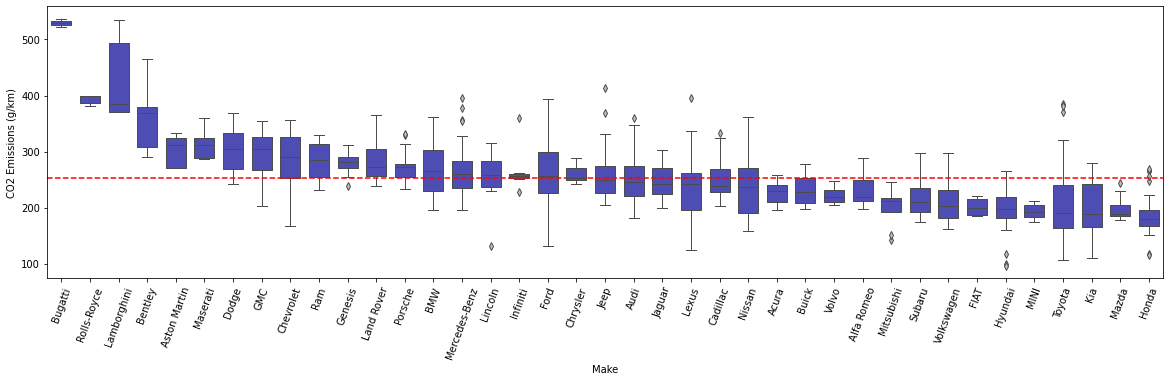

In [15]:
manufacturers_order = df.groupby('Make').median()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)['Make'].values
plt.figure(figsize=(20,5))
plt.xticks(rotation=70)
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')
sns.boxplot(data=df, x=df['Make'], y=df['CO2 Emissions (g/km)'], color='b', order=manufacturers_order, width=0.7, linewidth=1, saturation=0.4, flierprops=flierprops)
plt.axhline(df['CO2 Emissions (g/km)'].median(),color='r', linestyle='dashed')

 ## <a id="step_4">Step 4: Vehicle Classes</a>

Which vehicle classes are present in the dataset?

In [16]:
df['Vehicle Class'].unique()

array(['Compact', 'SUV: Small', 'Mid-size', 'Two-seater', 'Minicompact',
       'Subcompact', 'Station wagon: Small', 'Station wagon: Mid-size',
       'Full-size', 'SUV: Standard', 'Pickup truck: Small',
       'Pickup truck: Standard', 'Minivan', 'Van: Passenger',
       'Special purpose vehicle'], dtype=object)

Are there different amount of vehicle classes in the dataset? If so, which classes are represented more/less often represented due to the amount of different vehicles included? 

<AxesSubplot:xlabel='index', ylabel='Vehicle Class'>

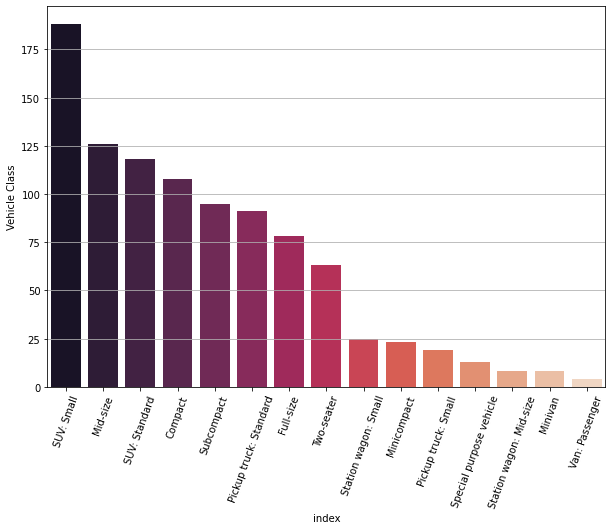

In [17]:
vehicleclass_counts = df['Vehicle Class'].value_counts().reset_index(drop=False)
plt.figure(figsize=(10,7))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=vehicleclass_counts, x=vehicleclass_counts['index'], y=vehicleclass_counts[vehicleclass_counts.columns[1]], palette="rocket")

#### Average CO2 emissions per vehicle class 

<AxesSubplot:xlabel='Vehicle Class', ylabel='CO2 Emissions (g/km)'>

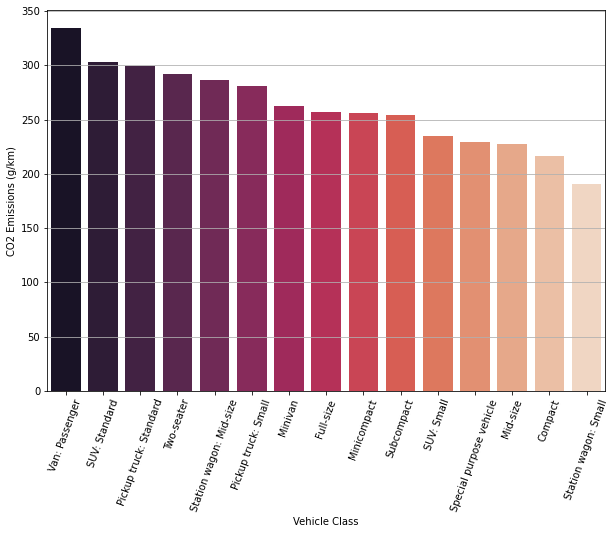

In [18]:
vehicleclass_CO2 = df.groupby('Vehicle Class').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(10,7))
plt.xticks(rotation=70)
plt.grid()
sns.barplot(data=vehicleclass_CO2, x=vehicleclass_CO2['Vehicle Class'], y=vehicleclass_CO2['CO2 Emissions (g/km)'], palette="rocket")

#### Vehicle Classes of manufacturers

In [19]:
vehicleclasses_per_manufacturer = {}
for manufacturer in df['Make'].unique():
    unique_vehicleclasses = df[df['Make']==manufacturer]['Vehicle Class'].unique()
    vehicleclasses_per_manufacturer[manufacturer] = list(unique_vehicleclasses)

In [20]:
df_vehicleclasses_per_manufacturer = pd.DataFrame(columns=df['Vehicle Class'].unique())
for key, value in vehicleclasses_per_manufacturer.items():
    vehicleclasses_row = [1 if class_ in value else 0 for class_ in df['Vehicle Class'].unique()]
    df_vehicleclasses_per_manufacturer.loc[key] = vehicleclasses_row
df_vehicleclasses_per_manufacturer = df_vehicleclasses_per_manufacturer.astype(int)

<AxesSubplot:>

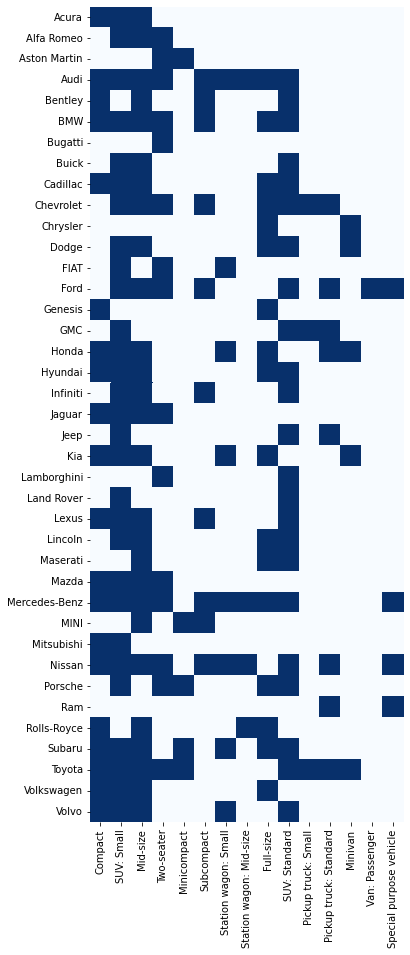

In [21]:
plt.figure(figsize=(10,15))
sns.heatmap(df_vehicleclasses_per_manufacturer, cmap="Blues", cbar=False, square=True)

## <a id="step_5">Step 5: Number Cylinders and Engine Size</a>

In [22]:
df['Cylinders'].unique()

array([ 4,  6,  8, 12, 10,  5, 16,  3], dtype=int64)

Text(0.5, 0, 'Cylinders')

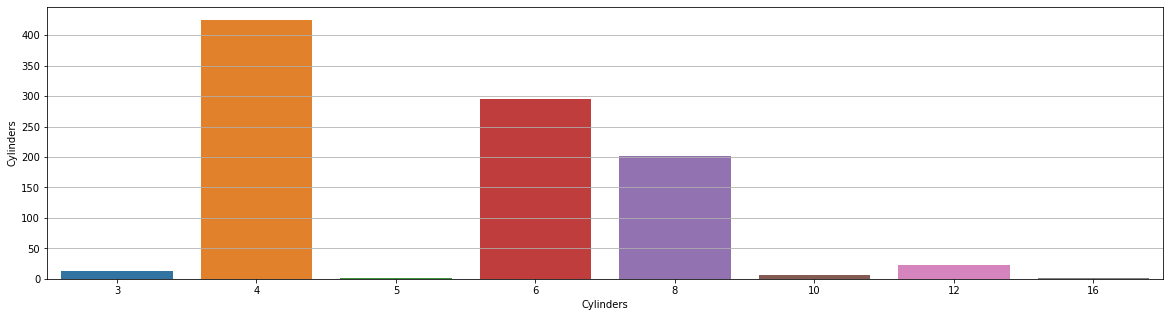

In [23]:
cylinders_counts = df['Cylinders'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.grid()

sns.barplot(data=cylinders_counts, x=cylinders_counts['index'], y=cylinders_counts[cylinders_counts.columns[1]])
plt.xlabel('Cylinders')

Most vehicles in the dataset have 4 Cylinders, followed by 6 and 8 Cylinders. 

<AxesSubplot:xlabel='Cylinders', ylabel='CO2 Emissions (g/km)'>

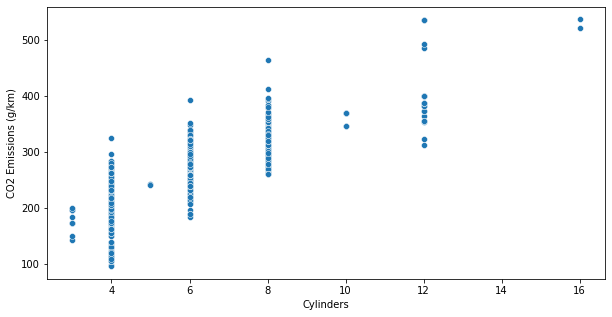

In [35]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Cylinders', y='CO2 Emissions (g/km)')

In [25]:
df['Engine Size (L)'].unique()

array([2.4, 3.5, 3. , 2. , 1.8, 2.9, 4. , 5.2, 2.5, 6. , 6.8, 4.4, 6.6,
       8. , 3.6, 1.4, 1.2, 1.3, 2.7, 4.2, 6.2, 2.8, 1.5, 4.3, 5.3, 5.7,
       6.4, 1. , 2.3, 3.3, 5. , 3.8, 1.6, 5.6, 3.2, 6.5, 4.6, 3.4, 3.7,
       4.7, 6.7])

Text(0.5, 0, 'Engine Size (L)')

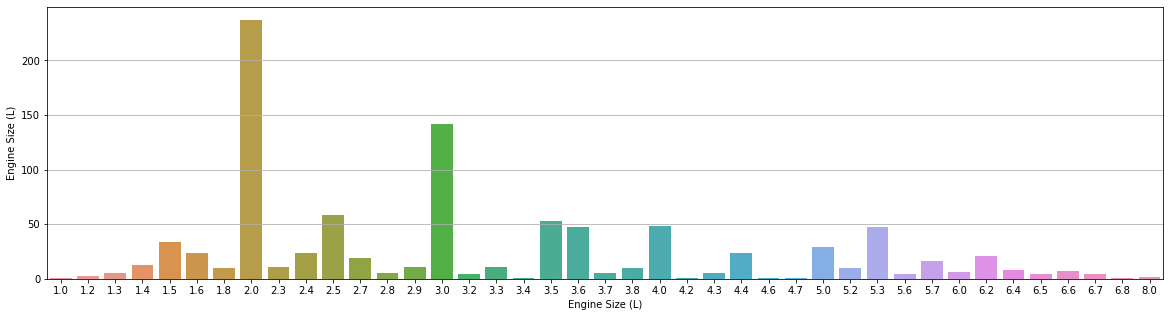

In [26]:
enginesize_counts = df['Engine Size (L)'].value_counts().reset_index(drop=False)
plt.figure(figsize=(20,5))
plt.grid()
sns.barplot(data=enginesize_counts, x=enginesize_counts['index'], y=enginesize_counts[enginesize_counts.columns[1]])
plt.xlabel('Engine Size (L)')

<AxesSubplot:xlabel='Engine Size (L)', ylabel='CO2 Emissions (g/km)'>

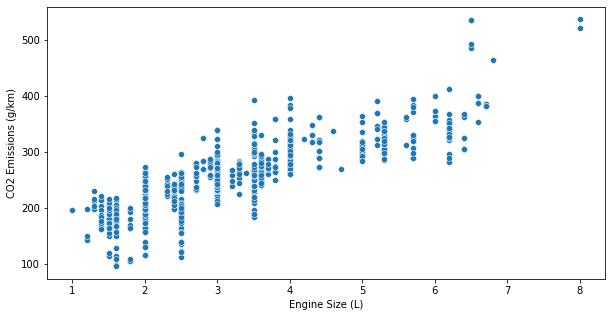

In [37]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Engine Size (L)', y='CO2 Emissions (g/km)')

## <a id="step_6">Step 6: Fuel Type</a>

In [27]:
df['Fuel Type'].unique()

array(['Z', 'X', 'D', 'E'], dtype=object)

As mentioned in the description, the fuel types included are:
- X = regular gasoline
- Z = premium gasoline
- D = diesel
- E = ethanol (E85)
- N = natural gas

Which means that there is no vehicle powered by natural gas in the dataset

<AxesSubplot:xlabel='index', ylabel='Fuel Type'>

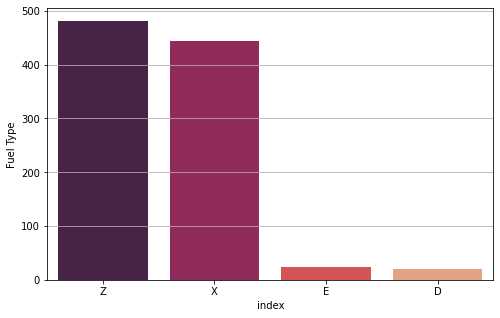

In [28]:
fueltype_counts = df['Fuel Type'].value_counts().reset_index(drop=False)
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(data=fueltype_counts, x=fueltype_counts['index'], y=fueltype_counts[fueltype_counts.columns[1]], palette="rocket")

In [29]:
df[df["Fuel Type"].str.contains("E|D")]['Make'].value_counts()

Ford          14
Chevrolet     12
GMC           11
Land Rover     3
Ram            2
Jeep           1
Name: Make, dtype: int64

There are just a few vehicles powered by Diesel and Ethanol. These are also for the largest part cars made by american car manufacturers like Ford, Chevrolet, GMC and RAM. 

<AxesSubplot:xlabel='Fuel Type', ylabel='CO2 Emissions (g/km)'>

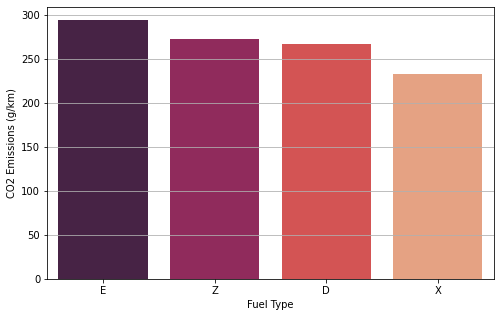

In [30]:
fueltype_CO2 = df.groupby('Fuel Type').mean()['CO2 Emissions (g/km)'].reset_index(drop=False).sort_values(by='CO2 Emissions (g/km)', ascending=False)
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(data=fueltype_CO2, x=fueltype_CO2['Fuel Type'], y=fueltype_CO2['CO2 Emissions (g/km)'], palette="rocket")

In [31]:
df[df["Fuel Type"].str.contains("E")]['Vehicle Class'].value_counts()

Pickup truck: Standard     10
SUV: Standard               8
Special purpose vehicle     2
Van: Passenger              2
Full-size                   1
Name: Vehicle Class, dtype: int64

Though ethanol and premium gasoline on average have the highest CO2 emissions, the vehicles present in the dataset that are powered by ethanol are all big, heavy cars like standard sized pickup trucks, SUVs, Vans, etc., which may distort the results shown in the graph 

<AxesSubplot:xlabel='Fuel Type', ylabel='CO2 Emissions (g/km)'>

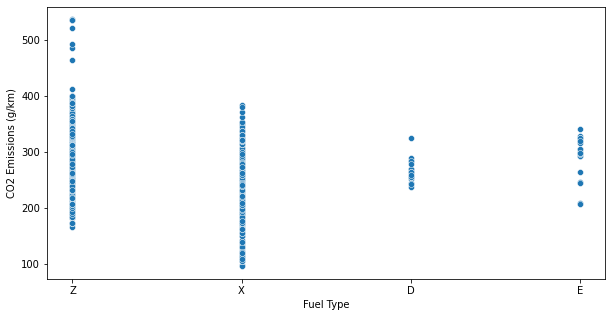

In [38]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Type', y='CO2 Emissions (g/km)')

Check correlation between the features of the dataset and the fuel consumption and CO2 emissions

<AxesSubplot:>

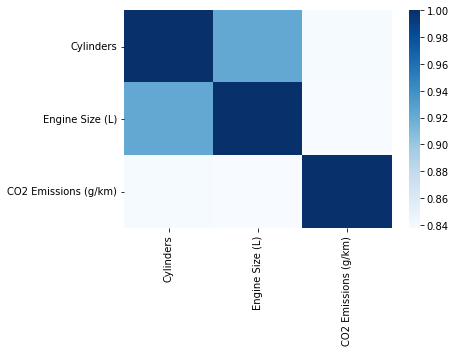

In [39]:
corr = df[['Cylinders', 'Engine Size (L)', 'CO2 Emissions (g/km)']].corr()
sns.heatmap(corr, cmap="Blues")

The Cylinders and Engine Size have a relatively high correlation with the CO2 emissions (above 0.84)

## <a id="step_8">Step 8: Fuel Consumption</a>

<AxesSubplot:>

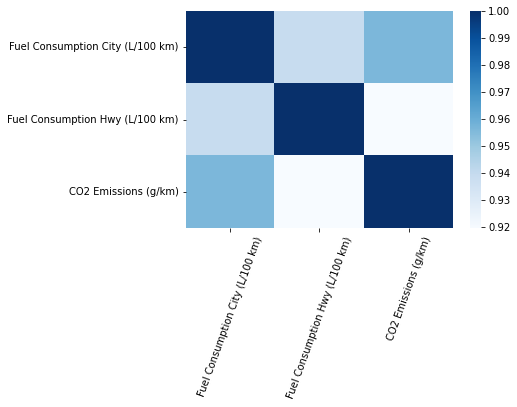

In [43]:
corr = df[['Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'CO2 Emissions (g/km)']].corr()
plt.xticks(rotation=70)
sns.heatmap(corr, cmap="Blues")

For the fuel consumption in the city and on the highway, the fuel consumption in the city has a higher correlation coefficient with the the CO2 emissions than the consumption on the highway. That is probably due to higher efficiency of the vehicles at higher speeds. Though both features have a very strong correlation due to a correlation coefficent above 0.92, which is even higher than the previous evaluated correlations including the number of cylinders and the engine size.
To get an idea of the relationship of the fuel consumption and the CO2 emissions we can look at the distribution. 

<AxesSubplot:xlabel='Fuel Consumption City (L/100 km)', ylabel='CO2 Emissions (g/km)'>

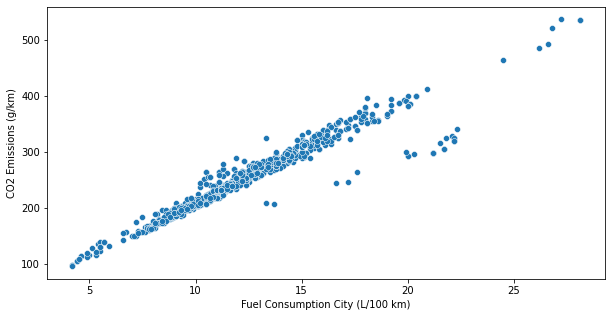

In [44]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Consumption City (L/100 km)', y='CO2 Emissions (g/km)')

<AxesSubplot:xlabel='Fuel Consumption Hwy (L/100 km)', ylabel='CO2 Emissions (g/km)'>

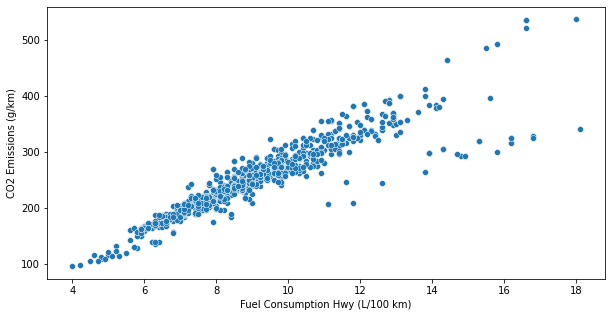

In [45]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Consumption Hwy (L/100 km)', y='CO2 Emissions (g/km)')

<AxesSubplot:xlabel='Fuel Consumption Comb (L/100 km)', ylabel='CO2 Emissions (g/km)'>

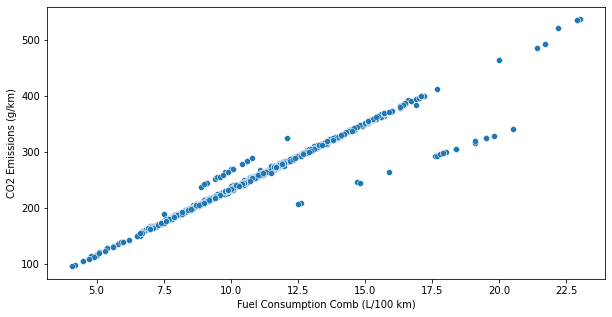

In [48]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)')

As the correlation matrix implies, the scatterplots show the strong relationship of the fuel consumption and the CO2 emissions. However, there are some outliers that distort the graph, as seen in the last graph. Let's check where the points come from. 

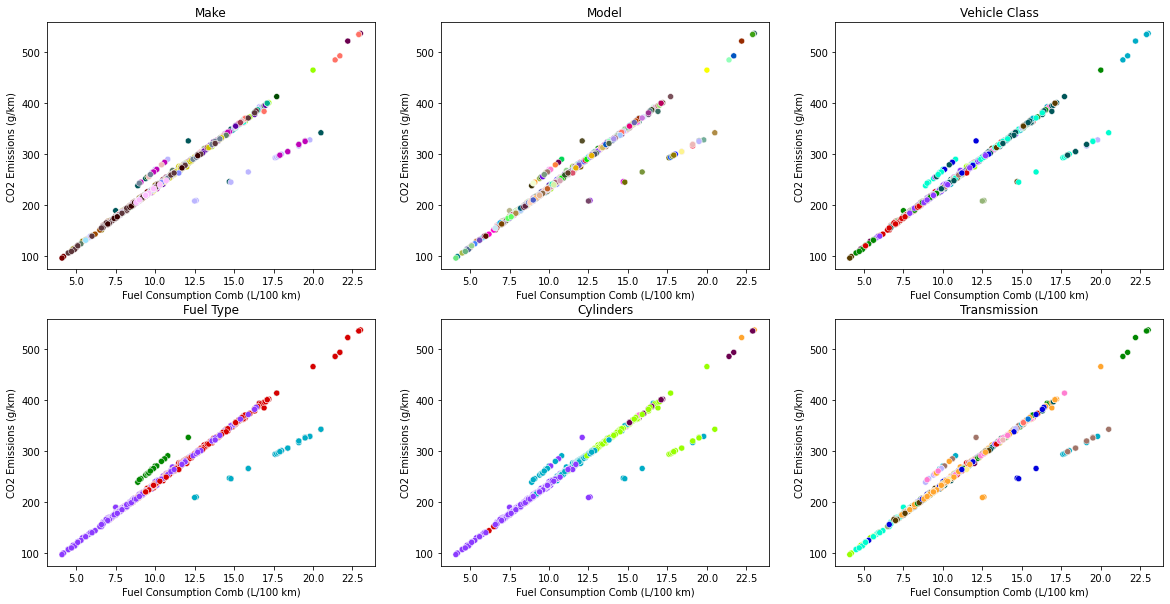

In [77]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
cols = ['Make', 'Model', 'Vehicle Class', 'Engine Size (L)', 'Cylinders', 'Transmission', 'Fuel Type']
nrow = 0
ncol = 0 
for col in cols:
    if ncol <=2:
        sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)',
                        hue=col, ax=axs[nrow, ncol], legend=False, palette=sns.color_palette(cc.glasbey, n_colors=len(df[col].unique())))
        axs[nrow, ncol].title.set_text(col)
        ncol += 1
    else:
        nrow = 1
        ncol = 0
        sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)',
                        hue=col, ax=axs[nrow, ncol], legend=False, palette=sns.color_palette(cc.glasbey, n_colors=len(df[col].unique())))
        axs[nrow, ncol].title.set_text(col)
        ncol += 1

So especially the Fuel Type indicates a relationship of these outliers. We already discovered, that some fuel types like ethanol distort the data by having a very small number of samples and some information that might be important, like the weight of the car, is missing.

<AxesSubplot:xlabel='Fuel Consumption Comb (L/100 km)', ylabel='CO2 Emissions (g/km)'>

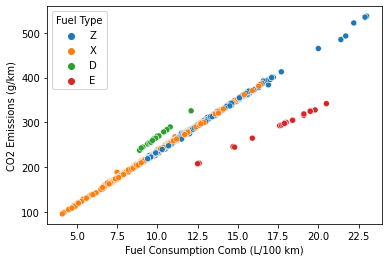

In [78]:
sns.scatterplot(data=df, x='Fuel Consumption Comb (L/100 km)', y='CO2 Emissions (g/km)', hue='Fuel Type')

So, as expected, the fuel types that form the outliers are the two fuel types, namely ethanol and diesel, that have a comparartively small number of samples.